In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

### 실습 과제 1. Boston_house_small 데이터를 활용한 PCA + regression 실습

#### 1) 데이터 불러온 후 train_data : test_data = 7:3 split, random_state=10
** 종속변수는 ‘Target', 독립변수는 나머지 변수

In [2]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('Boston_house_small.csv')

X = df.drop('Target', axis = 1)
y = df.loc[:,'Target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 10)

print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

(42, 13) (18, 13) (42,) (18,)


#### 2) PCA 수행해서 주성분(principal component) 개수에 따른 mean squared Error 그래프 그리고, principal component 개수에 따른 PCA의 explained_variance_ratio 구하기
**cross_val_score 함수 이용해서(cv=5) principal component 5개까지 mean squared error 구하기
 

Explained variance per principal component: [0.4903983  0.10552172 0.08436537 0.07794373 0.06522836]


array([49.04, 59.59, 68.03, 75.82, 82.34])

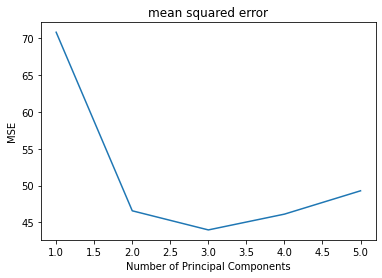

In [3]:
pca = PCA()
X_train_reduced = pca.fit_transform(scale(X_train))

reg = LinearRegression()
mse = []

for i in range(1,6):
    score = -1*cross_val_score(reg, X_train_reduced[:,:i], y_train, cv = 5, scoring = 'neg_mean_squared_error').mean()
    mse.append(score)
    
num_pc = np.arange(1,6)
plt.plot(num_pc,mse)
plt.xlabel("Number of Principal Components")
plt.ylabel("MSE")
plt.title('mean squared error')

print('Explained variance per principal component: {}'.format(pca.explained_variance_ratio_[:5]))

np.cumsum(np.round(pca.explained_variance_ratio_[:5], decimals = 4)*100)

#### 3) 가장 작은 mean squared error 가지는 주성분 개수로  PCA 수행하고, regression을 하기. 검증 데이터(test data)에 대한 mean squared error 구하고,  모델의 R^2 구하기

In [4]:
pca = PCA(n_components = 3)
X_train_reduced = pca.fit_transform(scale(X_train))
X_test_reduced = pca.transform(scale(X_test))

reg = LinearRegression()

reg.fit(X_train_reduced, y_train)
y_pred = reg.predict(X_test_reduced)

print('MSE : ',mean_squared_error(y_test,y_pred))
print('R^2 : ', r2_score(y_test,y_pred))

MSE :  36.42802456441783
R^2 :  0.730535127983386


#### 4)  PCA 없이 regression 하기. 검증 데이터(test data)에 대한 mean squared error 구하고,  모델이 R^2 구한 후 PCA를 수행한 결과와 비교하기

In [5]:
non_pca_reg = LinearRegression()

non_pca_reg.fit(X_train, y_train)
non_y_pred = non_pca_reg.predict(X_test)

print('MSE : ',mean_squared_error(y_test,non_y_pred))
print('R^2 : ', r2_score(y_test,non_y_pred))

MSE :  46.784062917116465
R^2 :  0.6539295864346173


### 실습 과제 2. Iris 데이터를 활용한 PCA + SVM 실습

#### 1) 데이터 불러온 후 train_data : test_data = 7:3 split, random_state=100
** 종속변수는 ‘Target', 독립변수는 나머지 변수

In [6]:
lris = pd.read_csv('Iris.csv')


lris_X = lris.drop('Species',axis = 1)
lris_y = lris.loc[:,'Species']

X_train, X_test, y_train, y_test = train_test_split(lris_X,lris_y,test_size = 0.3, random_state = 100)

print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

(105, 4) (45, 4) (105,) (45,)


#### 2) PCA 수행해서 주성분(principal component) 개수에 따른 accuracy그래프 그리기
**cross_val_score 함수 이용해서(cv=5) principal component 5개까지 accuracy 구하기

Text(0.5, 1.0, 'Accuracy')

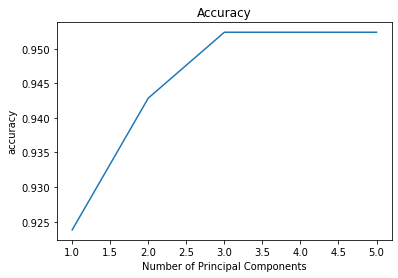

In [11]:
from sklearn import svm

pca = PCA()
accuracy = []
X_train_reduced = pca.fit_transform(X_train)

for i in range(1,6):
    score = cross_val_score(svm.SVC(), X_train_reduced[:,:i],y_train,cv = 5, scoring='accuracy').mean()
    accuracy.append(score)
    
num_pc = np.arange(1,6)
plt.plot(num_pc,accuracy)
plt.xlabel("Number of Principal Components")
plt.ylabel("accuracy")
plt.title('Accuracy')

#### 3) 높은 accuracy 가지는 주성분 개수로 PCA 수행하고, 5-fold 교차 검증으로 SVM의 최적 하이퍼파라미터 구하기. 검증 데이터(test data)에 대한 최적 모델의 accuracy와 confusion matrix 구하기
** C: [0.01, 0.1, 0.5, 1, 10, 100], gamma: [1, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001], kernel: ['rbf', 'poly', 'linear']

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

pca = PCA(n_components=3)

X_train_reduced = pca.fit_transform(scale(X_train))
X_test_reduced = pca.transform(scale(X_test))

pram_grid = {'C': [0.01, 0.1, 0.5, 1, 10, 100], 'gamma': [1, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'poly', 'linear']}

grid = GridSearchCV(svm.SVC(), pram_grid, cv = 5, scoring = 'accuracy', return_train_score = True)
grid.fit(X_train_reduced,y_train)

y_pred = grid.best_estimator_.predict(X_test_reduced)

print(grid.best_params_)
print('accuracy : ', metrics.accuracy_score(y_test,y_pred))
print('con_mat : ', metrics.confusion_matrix(y_test,y_pred))


{'C': 0.5, 'gamma': 1, 'kernel': 'linear'}
accuracy :  0.9333333333333333
con_mat :  [[16  0  0]
 [ 0 11  0]
 [ 0  3 15]]


#### 4) PCA 없이 최적 하이퍼파라미터로 SVM 모델 학습하기 , 검증 데이터(test data)에 대한 accuracy와 confusion matrix 구하기

In [13]:
non_svm = svm.SVC(kernel = 'linear', C = 0.5, gamma = 1)
non_svm.fit(X_train, y_train)

non_y_pred = non_svm.predict(X_test)

print('accuracy : ', metrics.accuracy_score(y_test,non_y_pred))
print('con_mat : ', metrics.confusion_matrix(y_test,non_y_pred))

accuracy :  1.0
con_mat :  [[16  0  0]
 [ 0 11  0]
 [ 0  0 18]]


In [14]:
X_train.shape

(105, 4)